In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [13]:
   
def getSpecies(x):
    if x == 0:
        return 'Not_Bat'
    elif x == 1:
        return 'Bat'
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted



# Ytrain in Onehot encoded form 
def makeOverSamplesSMOTE(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original trainingset shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    sm = SMOTE(sampling_strategy='all',k_neighbors=5)
    X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=2)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [14]:
#Load Bats
X_all = []
Y_all = []

image_folder_path = '../../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(1)


In [15]:
#Load Noise
image_folder_path = '../../data/noise'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(0)


In [16]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=2) 


(3426, 112, 170, 3)
(3426,)


In [17]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2> V1 !!!!! K-Fold Training and Evaluation</h2>

In [18]:
folder = "models"
mode_version = "bat_det_v1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/bat_det_v1


In [19]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(2, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [20]:
model = build_current_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_10 (Batc (None, 56, 85, 56)        224       
_________________________________________________________________
activation_10 (Activation)   (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 43, 56)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 22, 72)        1008

In [21]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=2

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1



    
    
    

Original trainingset shape [('Bat', 2172), ('Not_Bat', 294)]
Resampled training set shape [('Bat', 2172), ('Not_Bat', 2172)]
After OverSampling
X_train: shape=  (4344, 112, 170, 3)
Y_train: shape=  (4344, 2)
Epoch 1/100
543/543 - 6s - loss: 0.0673 - accuracy: 0.9779 - val_loss: 6.5542e-05 - val_accuracy: 1.0000
Epoch 2/100
543/543 - 2s - loss: 0.0260 - accuracy: 0.9929 - val_loss: 5.9856e-05 - val_accuracy: 1.0000
Epoch 3/100
543/543 - 2s - loss: 0.0227 - accuracy: 0.9952 - val_loss: 1.5505e-05 - val_accuracy: 1.0000
Epoch 4/100
543/543 - 2s - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.1909 - val_accuracy: 0.8784
Epoch 5/100
543/543 - 2s - loss: 0.0247 - accuracy: 0.9936 - val_loss: 2.5825e-04 - val_accuracy: 1.0000
Epoch 6/100
543/543 - 2s - loss: 0.0242 - accuracy: 0.9949 - val_loss: 1.3256e-04 - val_accuracy: 1.0000
Epoch 7/100
543/543 - 3s - loss: 0.0096 - accuracy: 0.9965 - val_loss: 1.8086e-05 - val_accuracy: 1.0000
Epoch 8/100
543/543 - 3s - loss: 0.0134 - accuracy: 0.9972 - 

Epoch 42/100
543/543 - 3s - loss: 0.0149 - accuracy: 0.9956 - val_loss: 1.5627e-04 - val_accuracy: 1.0000
Epoch 43/100
543/543 - 3s - loss: 0.0183 - accuracy: 0.9940 - val_loss: 8.2687e-06 - val_accuracy: 1.0000
Epoch 44/100
543/543 - 3s - loss: 0.0022 - accuracy: 0.9993 - val_loss: 2.6857e-06 - val_accuracy: 1.0000
Epoch 45/100
543/543 - 2s - loss: 0.0059 - accuracy: 0.9979 - val_loss: 3.7890e-05 - val_accuracy: 1.0000
Epoch 46/100
543/543 - 2s - loss: 0.0044 - accuracy: 0.9988 - val_loss: 5.0038e-06 - val_accuracy: 1.0000
Epoch 47/100
543/543 - 3s - loss: 0.0063 - accuracy: 0.9984 - val_loss: 1.7460e-06 - val_accuracy: 1.0000
Epoch 48/100
543/543 - 2s - loss: 0.0044 - accuracy: 0.9988 - val_loss: 4.6751e-06 - val_accuracy: 1.0000
Epoch 49/100
543/543 - 2s - loss: 0.0045 - accuracy: 0.9988 - val_loss: 4.9287e-07 - val_accuracy: 1.0000
Epoch 50/100
543/543 - 3s - loss: 0.0081 - accuracy: 0.9975 - val_loss: 3.6893e-06 - val_accuracy: 1.0000
Epoch 51/100
543/543 - 2s - loss: 0.0100 - acc

Epoch 14/100
543/543 - 2s - loss: 0.0159 - accuracy: 0.9956 - val_loss: 6.4990e-06 - val_accuracy: 1.0000
Epoch 15/100
543/543 - 3s - loss: 0.0129 - accuracy: 0.9975 - val_loss: 3.2709e-06 - val_accuracy: 1.0000
Epoch 16/100
543/543 - 2s - loss: 0.0272 - accuracy: 0.9938 - val_loss: 2.7621e-05 - val_accuracy: 1.0000
Epoch 17/100
543/543 - 3s - loss: 0.0100 - accuracy: 0.9982 - val_loss: 2.9021e-05 - val_accuracy: 1.0000
Epoch 18/100
543/543 - 3s - loss: 0.0176 - accuracy: 0.9942 - val_loss: 1.7005e-05 - val_accuracy: 1.0000
Epoch 19/100
543/543 - 3s - loss: 0.0168 - accuracy: 0.9963 - val_loss: 1.2744e-04 - val_accuracy: 1.0000
Epoch 20/100
543/543 - 3s - loss: 0.0042 - accuracy: 0.9993 - val_loss: 1.5058e-05 - val_accuracy: 1.0000
Epoch 21/100
543/543 - 2s - loss: 0.0119 - accuracy: 0.9961 - val_loss: 1.1090e-05 - val_accuracy: 1.0000
Epoch 22/100
543/543 - 3s - loss: 0.0150 - accuracy: 0.9956 - val_loss: 4.8881e-06 - val_accuracy: 1.0000
Epoch 23/100
543/543 - 3s - loss: 0.0203 - acc

Epoch 29/100
543/543 - 2s - loss: 0.0152 - accuracy: 0.9952 - val_loss: 2.5752e-05 - val_accuracy: 1.0000
Epoch 30/100
543/543 - 3s - loss: 0.0050 - accuracy: 0.9986 - val_loss: 1.1372e-05 - val_accuracy: 1.0000
Epoch 31/100
543/543 - 3s - loss: 0.0168 - accuracy: 0.9940 - val_loss: 9.6428e-05 - val_accuracy: 1.0000
Epoch 32/100
543/543 - 3s - loss: 0.0092 - accuracy: 0.9965 - val_loss: 5.7369e-06 - val_accuracy: 1.0000
Epoch 33/100
543/543 - 2s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 6.7584e-07 - val_accuracy: 1.0000
Epoch 34/100
543/543 - 3s - loss: 0.0057 - accuracy: 0.9979 - val_loss: 7.7077e-05 - val_accuracy: 1.0000
Epoch 35/100
543/543 - 3s - loss: 0.0233 - accuracy: 0.9942 - val_loss: 1.8629e-06 - val_accuracy: 1.0000
Epoch 36/100
543/543 - 2s - loss: 0.0121 - accuracy: 0.9940 - val_loss: 3.8464e-05 - val_accuracy: 1.0000
Epoch 37/100
543/543 - 3s - loss: 0.0140 - accuracy: 0.9961 - val_loss: 2.4529e-06 - val_accuracy: 1.0000
Epoch 38/100
543/543 - 3s - loss: 0.0138 - acc

Epoch 51/100
544/544 - 4s - loss: 0.0098 - accuracy: 0.9965 - val_loss: 1.3520e-05 - val_accuracy: 1.0000
Epoch 52/100
544/544 - 4s - loss: 0.0073 - accuracy: 0.9972 - val_loss: 1.9469e-06 - val_accuracy: 1.0000
Epoch 53/100
544/544 - 3s - loss: 0.0059 - accuracy: 0.9986 - val_loss: 1.8214e-06 - val_accuracy: 1.0000
Epoch 54/100
544/544 - 4s - loss: 0.0017 - accuracy: 0.9998 - val_loss: 5.2688e-07 - val_accuracy: 1.0000
Epoch 55/100
544/544 - 4s - loss: 0.0053 - accuracy: 0.9982 - val_loss: 2.3509e-06 - val_accuracy: 1.0000
Epoch 56/100
544/544 - 4s - loss: 0.0060 - accuracy: 0.9988 - val_loss: 9.7840e-07 - val_accuracy: 1.0000
Epoch 57/100
544/544 - 4s - loss: 0.0196 - accuracy: 0.9949 - val_loss: 4.2599e-05 - val_accuracy: 1.0000
Epoch 58/100
544/544 - 4s - loss: 0.0116 - accuracy: 0.9968 - val_loss: 6.8907e-05 - val_accuracy: 1.0000
Epoch 59/100
544/544 - 4s - loss: 0.0053 - accuracy: 0.9986 - val_loss: 7.5777e-05 - val_accuracy: 1.0000
Epoch 60/100
544/544 - 4s - loss: 0.0057 - acc

Epoch 2/100
544/544 - 4s - loss: 0.0336 - accuracy: 0.9933 - val_loss: 4.2543e-05 - val_accuracy: 1.0000
Epoch 3/100
544/544 - 4s - loss: 0.0144 - accuracy: 0.9965 - val_loss: 1.2088e-05 - val_accuracy: 1.0000
Epoch 4/100
544/544 - 5s - loss: 0.0131 - accuracy: 0.9965 - val_loss: 1.6988e-05 - val_accuracy: 1.0000
Epoch 5/100
544/544 - 5s - loss: 0.0139 - accuracy: 0.9965 - val_loss: 3.7051e-06 - val_accuracy: 1.0000
Epoch 6/100
544/544 - 4s - loss: 0.0190 - accuracy: 0.9963 - val_loss: 4.0204e-06 - val_accuracy: 1.0000
Epoch 7/100
544/544 - 4s - loss: 0.0285 - accuracy: 0.9917 - val_loss: 3.0974e-05 - val_accuracy: 1.0000
Epoch 8/100
544/544 - 4s - loss: 0.0224 - accuracy: 0.9940 - val_loss: 4.1469e-06 - val_accuracy: 1.0000
Epoch 9/100
544/544 - 4s - loss: 0.0222 - accuracy: 0.9940 - val_loss: 1.6436e-04 - val_accuracy: 1.0000
Epoch 10/100
544/544 - 3s - loss: 0.0239 - accuracy: 0.9933 - val_loss: 1.2327e-04 - val_accuracy: 1.0000
Epoch 11/100
544/544 - 3s - loss: 0.0152 - accuracy: 0

Epoch 00037: early stopping
models/bat_det_v1_iter_10.model
INFO:tensorflow:Assets written to: models/bat_det_v1_iter_10.model/assets


## Load and Evaluate

In [22]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=2


In [24]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    print('File Name Loaded: ',model_file)
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['Not_Bat', 'Bat']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

File Name Loaded:  models/bat_det_v1_iter_1.model
File Name Loaded:  models/bat_det_v1_iter_2.model
File Name Loaded:  models/bat_det_v1_iter_3.model
File Name Loaded:  models/bat_det_v1_iter_4.model
File Name Loaded:  models/bat_det_v1_iter_5.model
File Name Loaded:  models/bat_det_v1_iter_6.model
File Name Loaded:  models/bat_det_v1_iter_7.model
File Name Loaded:  models/bat_det_v1_iter_8.model
File Name Loaded:  models/bat_det_v1_iter_9.model
File Name Loaded:  models/bat_det_v1_iter_10.model


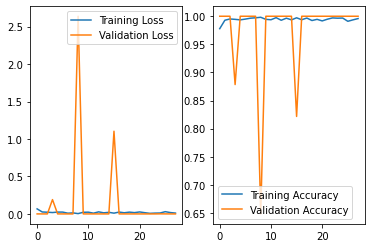

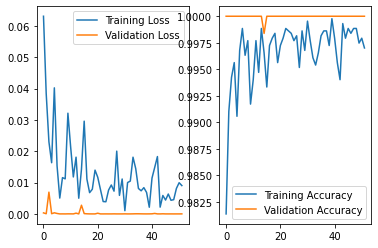

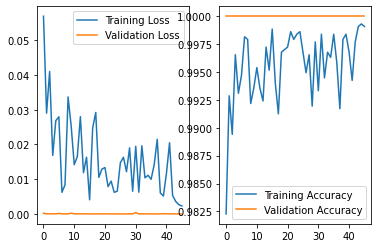

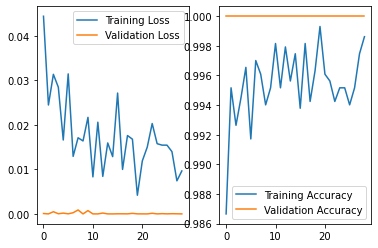

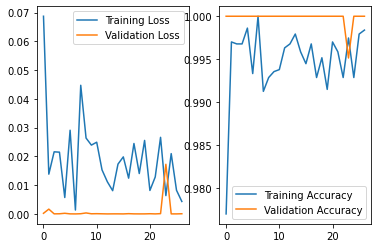

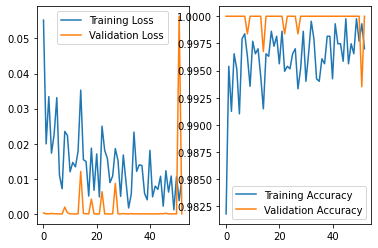

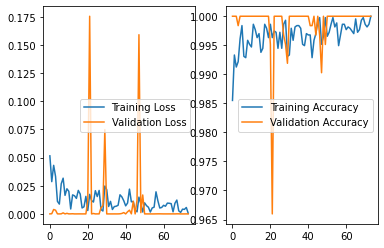

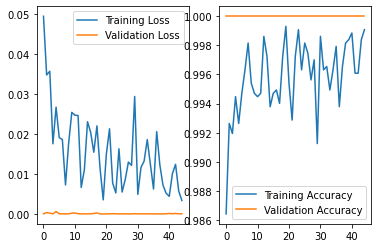

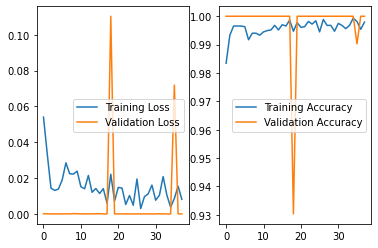

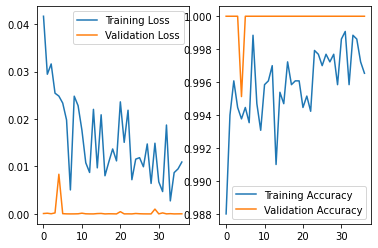

In [25]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [26]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1. 1.]
precision sdev by class [0. 0.]
macro precision mean 1.0
macro precision sdev 0.0
recall mean [1. 1.]
recall sdev [0. 0.]
macro recall mean 1.0
macro recall sdev 0.0
f1 mean [1. 1.]
f1 sdev [0. 0.]
macro f1 mean 1.0
macro f1 sdev 0.0
accuracy mean 1.0
accuracy sdev 0.0


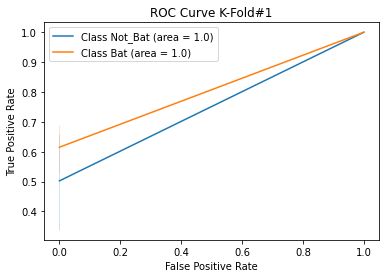

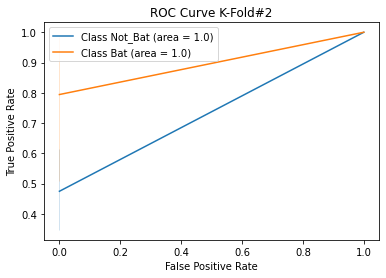

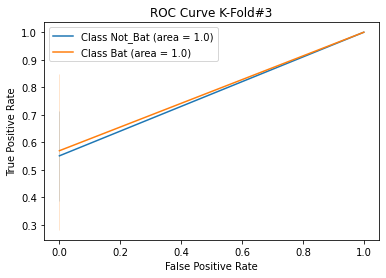

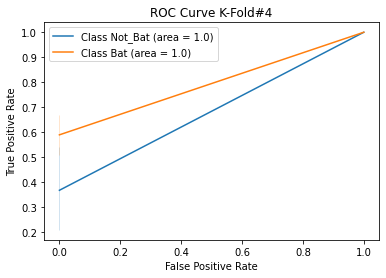

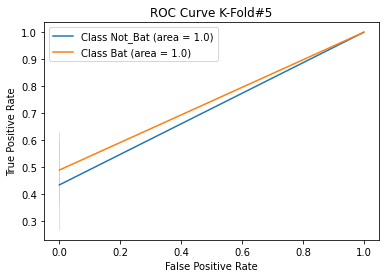

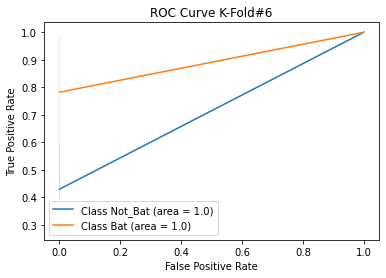

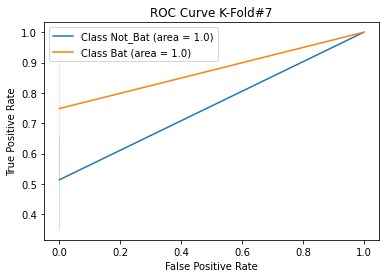

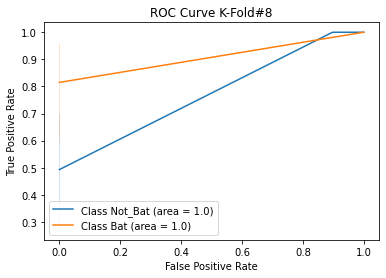

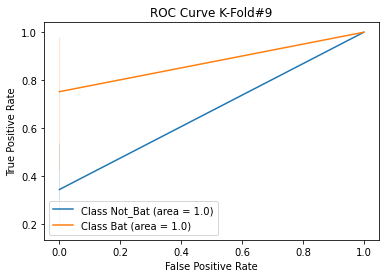

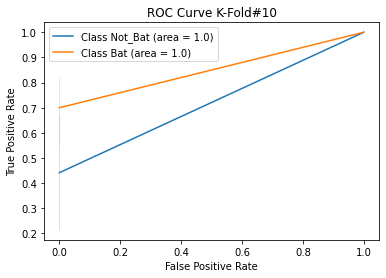

In [27]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [28]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  Not_Bat
AUC Mean  1.0
Std  0.0
Sp:  Bat
AUC Mean  1.0
Std  0.0


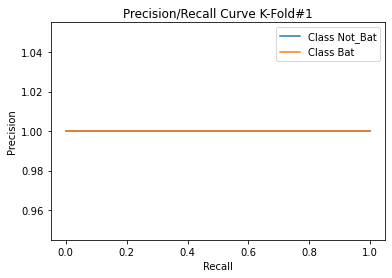

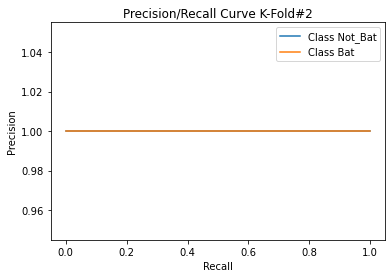

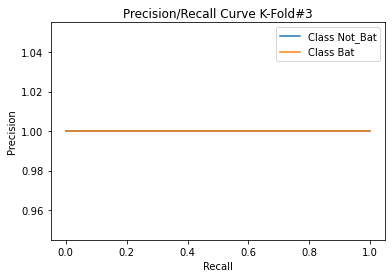

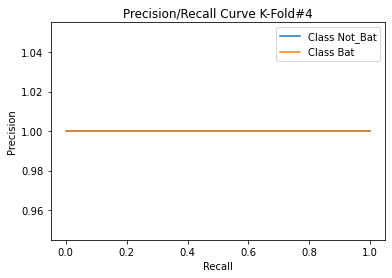

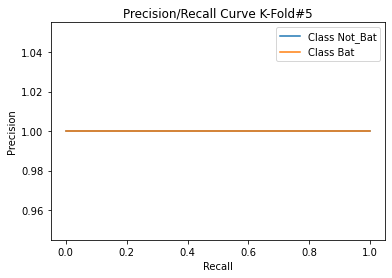

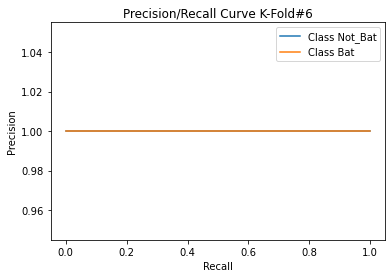

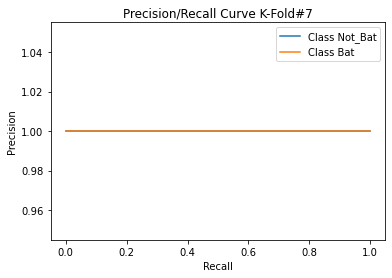

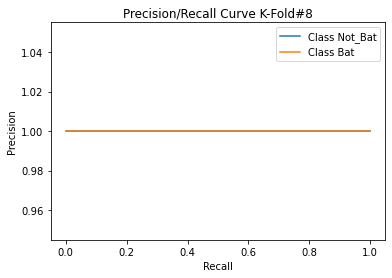

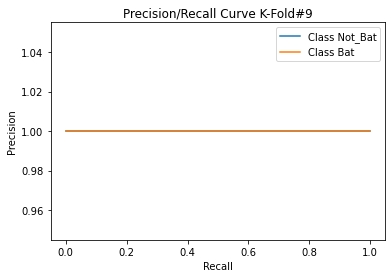

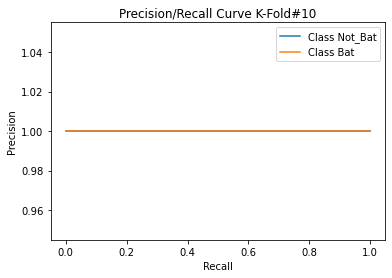

In [29]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[ 41   0]
 [  0 302]]


Confusion Matrix K-Fold #2

[[ 41   0]
 [  0 302]]


Confusion Matrix K-Fold #3

[[ 41   0]
 [  0 302]]


Confusion Matrix K-Fold #4

[[ 41   0]
 [  0 302]]


Confusion Matrix K-Fold #5

[[ 41   0]
 [  0 302]]


Confusion Matrix K-Fold #6

[[ 41   0]
 [  0 302]]


Confusion Matrix K-Fold #7

[[ 40   0]
 [  0 302]]


Confusion Matrix K-Fold #8

[[ 40   0]
 [  0 302]]


Confusion Matrix K-Fold #9

[[ 41   0]
 [  0 301]]


Confusion Matrix K-Fold #10

[[ 41   0]
 [  0 301]]




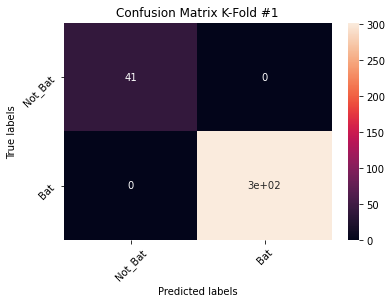

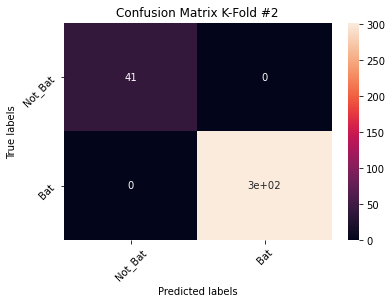

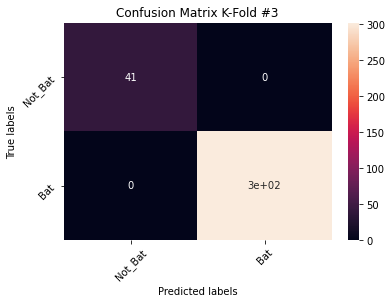

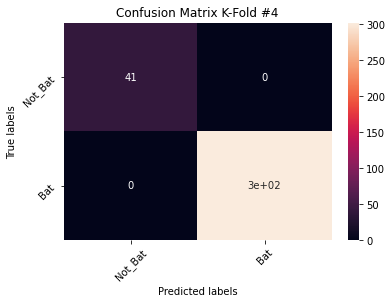

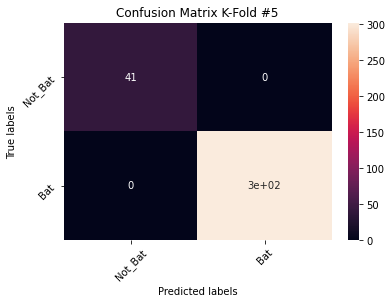

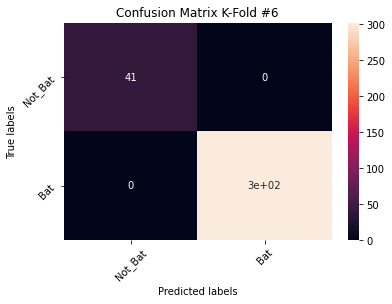

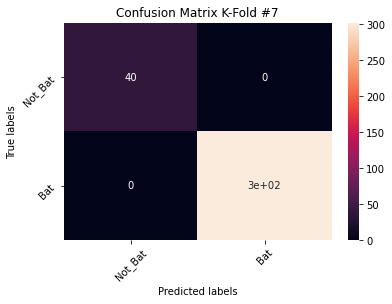

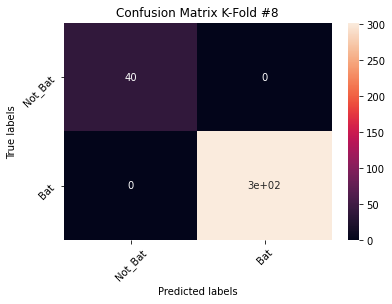

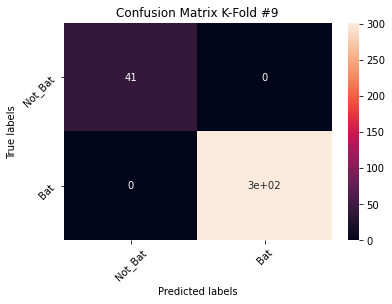

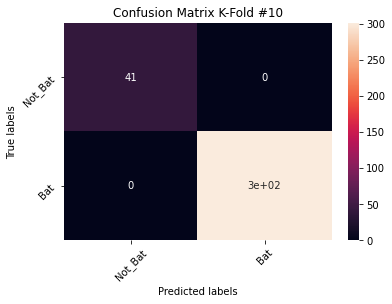

In [30]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[ 408    0]
 [   0 3018]]

average of all confuion matrices
 [[ 40   0]
 [  0 301]]


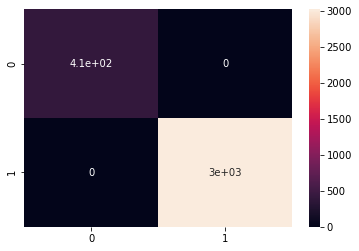

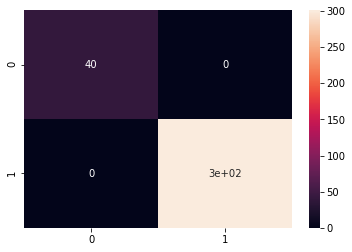

In [31]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[1. 0.]
 [0. 1.]]


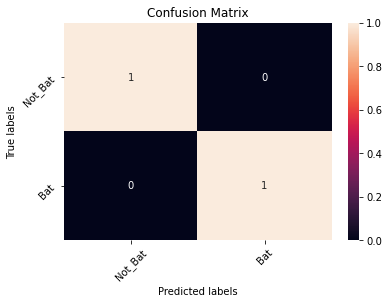

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['Not_Bat', 'Bat']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);